# Simple CNN Model (Model 7)

Model 7, class imbalance accounted for, similar to Model 3 except for one additional FC layer and dropout layer

## Imports

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle, os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import set_random_seed
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from src.sampler import sample_weighter
from src.model_api import getSimpleModelV7
from src.prediction import array_filter, array_to_string
from src.custom_metric import as_keras_metric

Using TensorFlow backend.


Import data

In [3]:
with open('data/derived/data_train.pickle', 'rb') as file:
    data_train = pickle.load(file)
with open('data/derived/labels_train.pickle', 'rb') as file:
    labels_train = pickle.load(file)
print('Shape of data_train:', data_train.shape)
print('Length of labels_train:', len(labels_train))

Shape of data_train: (25361, 100, 100, 3)
Length of labels_train: 25361


In [4]:
with open('data/derived/data_test.pickle', 'rb') as file:
    data_test = pickle.load(file)
with open('data/derived/test_file_names.pickle', 'rb') as file:
    filenames_test = pickle.load(file)
print('Shape of data_test:', data_test.shape)
print('Length of filename_test:', len(filenames_test))

Shape of data_test: (7960, 100, 100, 3)
Length of filename_test: 7960


Convert labels to integers for model training

In [5]:
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
print('Original labels: {}'.format(labels_train[:5]))
print('Encoded labels: {}'.format(labels_train_encoded[:5]))
print('Label encoder classes: {}'.format(label_encoder.classes_[:5]))

Original labels: ['new_whale', 'new_whale', 'w_75d0e61', 'w_396c12b', 'w_d8de44c']
Encoded labels: [   0    0 2308 1134 4209]
Label encoder classes: ['new_whale' 'w_0003639' 'w_0003c59' 'w_0027efa' 'w_00289b1']


Compute sample size and number of classes

In [6]:
sample_size = len(labels_train_encoded)
num_classes = len(set(labels_train_encoded))
print('Sample size:', sample_size)
print('Number of clases:', num_classes)

Sample size: 25361
Number of clases: 5005


## Train Single CNN Model

Simple CNN model (Random Seed = 2019, assuming class imbalance)

In [7]:
X_train = (data_train / 255).astype(np.float32)
y_train = to_categorical(labels_train_encoded, num_classes=num_classes)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (25361, 100, 100, 3)
Shape of y_train: (25361, 5005)


In [8]:
filepath = 'models/weights-model7-{epoch:03d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=False, save_weights_only=True,
                             mode='min')

# Create precision and recall metrics
# Note: top_k_categorical_accuracy function in keras.metrics has default k value of 5
top_5_categorical_accuracy = keras.metrics.top_k_categorical_accuracy
f1_score = as_keras_metric(tf.contrib.metrics.f1_score)
metric_list = [top_5_categorical_accuracy, f1_score]

# Compute sample weights
sample_weight_array = sample_weighter(labels_array=labels_train_encoded)

model = getSimpleModelV7(num_classes=num_classes, resize_width=100, metric_list=metric_list)

In [17]:
np.random.seed(2019)
set_random_seed(2019)
model.load_weights('models/weights-model7-290.hdf5')
model.fit(X_train, y_train, epochs=300, shuffle=True, sample_weight=sample_weight_array,
          callbacks=[checkpoint], initial_epoch=290)

Epoch 291/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2310e-04 - top_k_categorical_accuracy: 0.7170 - f1_score: 0.6658
Epoch 292/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2399e-04 - top_k_categorical_accuracy: 0.7133 - f1_score: 0.6654
Epoch 293/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2430e-04 - top_k_categorical_accuracy: 0.7111 - f1_score: 0.6650
Epoch 294/300
25361/25361 [==============================] - 26s 1ms/step - loss: 1.2300e-04 - top_k_categorical_accuracy: 0.7149 - f1_score: 0.6646
Epoch 295/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2400e-04 - top_k_categorical_accuracy: 0.7130 - f1_score: 0.6642
Epoch 296/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2310e-04 - top_k_categorical_accuracy: 0.7172 - f1_score: 0.6639
Epoch 297/300
25361/25361 [==============================] - 27s 1ms/step - loss: 1.2321e-04 - top_k_categ

Evaluate models

In [21]:
model.load_weights('models/weights-model7-001.hdf5')
print(model.metrics_names)
print(model.evaluate(X_train, y_train))

['loss', 'top_k_categorical_accuracy', 'f1_score']
25361/25361 [==============================] - 15s 577us/step
[6.092919470755198, 0.39134892158071904, 0.45393234214724054]


In [18]:
epoch_no_total = 300
top_5_accuracy_list = []
f1_score_list = []
for epoch_no in range(1, epoch_no_total + 1):
    model.load_weights('models/weights-model7-{:03d}.hdf5'.format(epoch_no))
    _, top_5_accuracy, f1_score = model.evaluate(X_train, y_train, verbose=0)
    top_5_accuracy_list.append(top_5_accuracy)
    f1_score_list.append(f1_score)

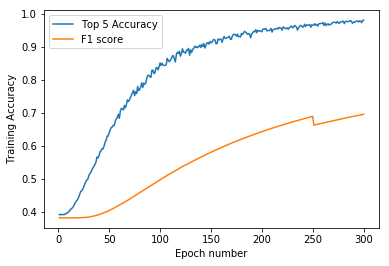

In [19]:
plt.plot(list(range(1, epoch_no_total + 1)), top_5_accuracy_list, label='Top 5 Accuracy')
plt.plot(list(range(1, epoch_no_total + 1)), f1_score_list, label='F1 score')
plt.xlabel('Epoch number')
plt.ylabel('Training Accuracy')
plt.legend(loc='best')

Model prediction

In [20]:
data_test_norm = (data_test / 255).astype(np.float32)

model.load_weights('models/weights-model7-120.hdf5')

# Save final weights if it doesn't exist
weights_path = 'models/weights-model7-final.hdf5'
if os.path.exists(weights_path):
    print('Path {} exists'.format(weights_path))
else:
    model.save_weights(weights_path)

preds = model.predict(data_test_norm)

Obtain labels with top 5 softmax values for each array row and concatenate labels

In [21]:
top5_indices = np.apply_along_axis(array_filter, arr=preds, axis=1, n_top=5, labels=label_encoder.classes_)
predictions_array = np.apply_along_axis(array_to_string, arr=top5_indices, axis=1)

Create submission DataFrame and export as CSV file

In [22]:
submission_df = pd.DataFrame({'Image': filenames_test, 'Id': predictions_array})
submission_df.to_csv('data/derived/submission_v7.csv', index=False)
print(submission_df.head())

           Image                                                 Id
0  660352b03.jpg  new_whale w_564a34b w_9da1811 w_b9c99cc w_b4fe6b0
1  bec66f23c.jpg  new_whale w_3002b59 w_6ad771b w_488865e w_59052ad
2  fb8c2c146.jpg  new_whale w_83cc0ec w_9713cc3 w_d72771c w_73282ec
3  0ff9cd790.jpg  new_whale w_c158581 w_c0e2505 w_553d3d0 w_c85ff1e
4  861e6c332.jpg  new_whale w_75f6ffa w_b938e96 w_af367c3 w_27597ff


Kaggle score: 0.301